<h1><center> OCT PROJET 


<h2> Imports

In [201]:
import os
from PIL import Image, ImageTk
from random import randint
import glob
from IPython.display import clear_output

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt, savgol_filter
import tkinter as tk
from tkinter import filedialog, messagebox
import imageio 
import plotly.graph_objects as go
from scipy.interpolate import griddata
import skimage as ski
import json

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import binary_crossentropy

<h2> Normalisation des images

In [202]:
# recopie de la configuration des répertoires pour les outputs
BASE_DATA_PATH = "./"
IMAGE_DIR = os.path.join(BASE_DATA_PATH, "IMAGES/IMAGES/")
ALL_IMAGES_DIR = [os.path.join(IMAGE_DIR, x) for x in os.listdir(IMAGE_DIR)]
OUTPUT_DIR = os.path.join(BASE_DATA_PATH, "OUTPUT_CROPPED")
ALL_OUTPUT_DIR = [os.path.join(OUTPUT_DIR, x) for x in os.listdir(IMAGE_DIR)]

[os.makedirs(x, exist_ok=True) for x in ALL_OUTPUT_DIR]
os.makedirs(OUTPUT_DIR, exist_ok=True)

CROP_X_START = 495
CROP_Y_START = 0 
# CROP_X_END = 2000 est codé dynamiquement en fonction de l'image
CROP_Y_END = 496  

In [203]:

# --- Fonctions ---
def load_image(image_path):
    img = cv2.imread(image_path) # Charger en couleur au cas où pour l'affichage
    if img is None:
        print(f"Erreur : Impossible de charger l'image à {image_path}")
    return img

def crop_image(image, x_start, y_start, x_end, y_end):
    if image is None:
        return None
    # S'assurer que les coordonnées sont valides
    h, w = image.shape[:2]
    x_s = max(0, x_start)
    y_s = max(0, y_start)
    x_e = min(w, x_end)
    y_e = min(h, y_end)

    if x_s >= x_e or y_s >= y_e:
        print(f"Erreur de recadrage: coordonnées invalides ({x_s},{y_s}) à ({x_e},{y_e}) pour une image de taille {w}x{h}")
        return image # ou None
    
    cropped = image[y_s:y_e, x_s:x_e]
    return cropped

def display_comparison(original_img, cropped_img, title_original="Originale", title_cropped="Recadrée"):
    if original_img is None or cropped_img is None:
        print("Une des images est None, impossible d'afficher.")
        return
        
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(title_original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title(title_cropped)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_image(image):
    
    plt.imshow(image, cmap='gray')
    plt.show()


def get_image_tif_files(DIR):
    
    return glob.glob(os.path.join(DIR, "*.tif"))
    
def get_image_png_files(DIR):
    
    return glob.glob(os.path.join(DIR, "*.png"))

In [204]:
def crop_bscan(all_input_directory : list ,all_output_directory:list, debug = False , type="png"):
    ''' 
    Recadre les B-scans d'une série d'images en fonction des coordonnées définies    
    Arguments:
        - all_input_directory (list) :  répertoires contenant les images à réduire
        - debug (bool): si true, active les prints
        - type (str): type de fichier à traiter, ici png
        - all_output_directory (list): répertoires de sortie pour les images recadrées
    '''

    for indice,image_dir in enumerate(all_input_directory):
        image_files = glob.glob(os.path.join(image_dir, f"*.{type}")) # Ou .png, .jpg
        if not image_files:
            print(f"Aucun fichier .tif trouvé dans {image_dir}. Vérifiez le chemin et l'extension.")
            exit()

        for img_path in image_files:

            if debug:
                print(f"Traitement de : {img_path}")

            current_full_image = load_image(img_path)
            largeur = current_full_image.shape[1] - 10
            if current_full_image is not None:
                current_cropped_bscan = crop_image(current_full_image, CROP_X_START, CROP_Y_START, largeur, CROP_Y_END)
                if current_cropped_bscan is not None and current_cropped_bscan.size > 0:
                    output_filename = os.path.join(all_output_directory[indice], os.path.basename(img_path))
                    cv2.imwrite(output_filename, current_cropped_bscan)

                    if debug:
                        print(f"  -> Sauvegardée : {output_filename}")
                else:
                    if debug:
                        print(f"  -> Échec du recadrage pour {img_path}")

<h3> Crop de toutes les images

In [205]:
crop_bscan(ALL_IMAGES_DIR,ALL_OUTPUT_DIR)
# si on ne veux que traiter un seul repertoire il faut en faire une liste de 1 répertoire

<h1> Segmentation de la rétine

Méthode n°1 : 
<br>-Prétraitement (par B-scan recadré) : Améliorer la qualité de l'image pour faciliter la segmentation.
<br>-Segmentation de l'ILM (Internal Limiting Membrane) : C'est la première interface hyper-réflective (brillante) en partant du vitré (la zone sombre en haut).
<br>-Segmentation de la Limite Externe du HRC (Hyper-Reflective Complex) : C'est une autre couche brillante, plus profonde que l'ILM. Sa position est souvent relative à l'ILM.
<br>-Post-traitement : Lisser les courbes segmentées, combler les petits trous.

In [206]:
def pre_filtrage(cropped_bscan):

    gray_bscan = cv2.cvtColor(cropped_bscan, cv2.COLOR_BGR2GRAY)

    # Filtre Gaussien
    blurred = cv2.GaussianBlur(gray_bscan, (5, 5), 0) # Ajustez la taille du noyau

    # Ou Filtre Médian (bon pour le bruit poivre et sel)
    blurred = cv2.medianBlur(gray_bscan, 5)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(blurred)
    image_to_process = contrast_enhanced
    # Ou utiliser 'blurred' directement si le contraste est déjà bon
    return blurred

In [207]:
def segment_ilm_gradient_based(image_processed):
    ilm_line = np.zeros(image_processed.shape[1], dtype=int)
    # Réduire la zone de recherche pour l'ILM (par exemple, le tiers supérieur de l'image)
    search_roi_y_end = image_processed.shape[0] 

    for x in range(image_processed.shape[1]):
        column = image_processed[:search_roi_y_end, x]
        
        # Calculer le gradient vertical (différence simple ou Sobel)
        # grad_y = np.diff(column.astype(float)) # Simple diff, longueur N-1
        # Ou utiliser Sobel pour un gradient plus robuste
        sobel_y = cv2.Sobel(column, cv2.CV_64F, 0, 1, ksize=3) # Gradient en Y

        # Trouver le premier pic positif important
        # On cherche une transition sombre -> clair, donc un gradient positif important
        # (ou un pic négatif si on utilise diff et qu'on regarde la valeur d'avant)
        
        # Simplification: trouver le premier pixel au-dessus d'un seuil après lissage
        # Cette partie est très similaire à la méthode simple mais sur une image mieux préparée
        # et avec un ROI. Une vraie détection de pic de gradient serait mieux.
        
        # Pour une approche "premier pixel au-dessus d'un seuil dans ROI" (plus simple à coder ici)
        threshold_val = np.mean(column) + np.std(column) # Seuil adaptatif simple
        potential_points = np.where(column > threshold_val)[0]

        if len(potential_points) > 0:
            ilm_line[x] = potential_points[0]
        else:
            # Gérer le cas où rien n'est trouvé (ex: prendre la moyenne des voisins)
            if x > 0:
                ilm_line[x] = ilm_line[x-1] 
            else:
                ilm_line[x] = search_roi_y_end // 2 # Estimation grossière
    return ilm_line

def segment_hrc_relative_to_ilm(image_processed, ilm_line, search_offset=30, search_height=100):
    hrc_line = np.zeros(image_processed.shape[1], dtype=int)
    
    for x in range(image_processed.shape[1]):
        start_y_hrc = ilm_line[x] + search_offset
        end_y_hrc = min(image_processed.shape[0], start_y_hrc + search_height)
        
        if start_y_hrc >= end_y_hrc: # Si l'ILM est trop basse ou la bande trop petite
             if x > 0: hrc_line[x] = hrc_line[x-1]
             else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
             continue

        column_roi = image_processed[start_y_hrc:end_y_hrc, x]
        
        if column_roi.size == 0:
            if x > 0: hrc_line[x] = hrc_line[x-1]
            else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
            continue

        # Trouver le pixel le plus brillant dans ce ROI
        # Ceci est une simplification. Une détection de gradient ou de pic serait mieux.
        max_intensity_idx_in_roi = np.argmax(column_roi)
        hrc_line[x] = start_y_hrc + max_intensity_idx_in_roi
        
    return hrc_line

In [ ]:
def segment_hrc_band(image_processed, ilm_line,
                     offset_to_hrc_top_search_start=25, # Augmenté par défaut
                     hrc_complex_search_height=100,
                     hrc_band_expected_min_thickness=10,
                     hrc_band_expected_max_thickness=50,
                     hrc_top_brightness_factor_vs_ilm=1.15, # HRC_top doit être X% plus brillant que l'ILM
                     hrc_top_brightness_factor_vs_roi_mean=1.0 # HRC_top doit être X * std_dev au-dessus de la moyenne ROI HRC
                    ):
    hrc_top_line = np.zeros(image_processed.shape[1], dtype=float)
    hrc_bottom_line = np.zeros(image_processed.shape[1], dtype=float)
    img_height, img_width = image_processed.shape

    for x in range(img_width):
        # Définir la ROI verticale globale pour chercher le complexe HRC
        # S'assurer que ilm_line[x] est un index valide
        current_ilm_y = int(ilm_line[x])
        if not (0 <= current_ilm_y < img_height): # Si ILM est hors limites, fallback
            current_ilm_y = img_height // 3 # Estimation grossière

        search_roi_start_y = current_ilm_y + offset_to_hrc_top_search_start
        search_roi_end_y = min(img_height, search_roi_start_y + hrc_complex_search_height)

        # S'assurer que la ROI est valide et a une taille minimale
        if search_roi_start_y >= img_height or search_roi_start_y >= search_roi_end_y or (search_roi_end_y - search_roi_start_y) < 5 :
            hrc_top_line[x] = hrc_top_line[x-1] if x > 0 else current_ilm_y + offset_to_hrc_top_search_start + 5
            hrc_bottom_line[x] = hrc_bottom_line[x-1] if x > 0 else hrc_top_line[x] + hrc_band_expected_min_thickness + 5
            hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height -1) # Clamp
            hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height -1) # Clamp
            continue

        column_hrc_roi = image_processed[int(search_roi_start_y):int(search_roi_end_y), x]

        if column_hrc_roi.size == 0: # Devrait être couvert par la vérification précédente, mais par sécurité
            hrc_top_line[x] = hrc_top_line[x-1] if x > 0 else current_ilm_y + offset_to_hrc_top_search_start + 5
            hrc_bottom_line[x] = hrc_bottom_line[x-1] if x > 0 else hrc_top_line[x] + hrc_band_expected_min_thickness + 5
            hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height -1)
            hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height -1)
            continue

        # --- Trouver HRC_top ---
        current_hrc_top_local_idx = -1

        # Définir un seuil d'intensité exigeant pour HRC_top
        intensity_at_ilm = image_processed[current_ilm_y, x]
        
        # Seuil 1: basé sur la brillance relative à l'ILM
        threshold_vs_ilm = intensity_at_ilm * hrc_top_brightness_factor_vs_ilm
        
        # Seuil 2: basé sur la distribution de la ROI HRC
        mean_roi = np.mean(column_hrc_roi)
        std_roi = np.std(column_hrc_roi)
        threshold_vs_roi_stat = mean_roi + hrc_top_brightness_factor_vs_roi_mean * std_roi
        
        # Le seuil final est le plus strict des deux (ou d'autres combinaisons)
        # Ici, on prend le max, ce qui signifie que le pixel doit satisfaire les deux conditions si elles sont pertinentes
        # Ou une condition OU l'autre, selon la logique (ici, on prend le max pour être plus strict)
        final_threshold_top = max(threshold_vs_ilm, threshold_vs_roi_stat, mean_roi + 5) # Ajout d'un seuil minimal au-dessus de la moyenne

        # Chercher le premier pixel dans column_hrc_roi qui dépasse ce seuil strict
        # On limite la recherche à la première partie de la ROI pour éviter confusion avec HRC_bottom
        search_limit_hrc_top_local = len(column_hrc_roi) * 2 // 3 # ex: chercher dans les 2/3 supérieurs de la ROI HRC
        
        potential_top_indices = np.where(column_hrc_roi[:search_limit_hrc_top_local] > final_threshold_top)[0]
        
        if len(potential_top_indices) > 0:
            current_hrc_top_local_idx = potential_top_indices[0]
        else:
            # Fallback si le seuil strict ne trouve rien:
            # Chercher le pixel le plus brillant dans la première moitié de la ROI HRC.
            # Cela peut arriver si l'HRC n'est pas aussi brillant que prévu par les facteurs.
            first_half_roi = column_hrc_roi[:len(column_hrc_roi)//2]
            if first_half_roi.size > 0:
                current_hrc_top_local_idx = np.argmax(first_half_roi)
            else: # Si même la première moitié est vide (ROI très petite)
                current_hrc_top_local_idx = 0 # Prendre le début de la ROI

        # Si current_hrc_top_local_idx est toujours -1 (ce qui ne devrait pas arriver avec le fallback argmax),
        # ou s'il est trop bas dans la ROI (ce qui contredit l'idée de "top")
        # Ce fallback est moins probable maintenant.
        if current_hrc_top_local_idx == -1 : # Ne devrait plus arriver
             max_intensity_idx_in_overall_roi = np.argmax(column_hrc_roi)
             current_hrc_top_local_idx = max(0, max_intensity_idx_in_overall_roi - hrc_band_expected_min_thickness//2) # Estimation

        hrc_top_line[x] = search_roi_start_y + current_hrc_top_local_idx


        # --- Trouver HRC_bottom ---
        # (La logique pour HRC_bottom reste globalement la même que votre version précédente,
        # mais elle commence sa recherche à partir du HRC_top trouvé)

        # Assurer que HRC_top n'est pas trop bas pour laisser de la place à HRC_bottom
        # Et que start_search_bottom_local_idx est valide
        # On veut que HRC_bottom soit au moins quelques pixels après HRC_top
        min_dist_top_to_start_bottom = max(1, hrc_band_expected_min_thickness // 3) # Ex: au moins 1/3 de l'épaisseur min
        start_search_bottom_local_idx = int(current_hrc_top_local_idx + min_dist_top_to_start_bottom)
        
        # S'assurer que start_search_bottom_local_idx ne dépasse pas la fin de column_hrc_roi
        if start_search_bottom_local_idx >= len(column_hrc_roi):
            # Si HRC_top est trop proche de la fin de la ROI, HRC_bottom est juste un peu après
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness
            hrc_bottom_line[x] = min(hrc_bottom_line[x], search_roi_end_y -1) # borner
            # Il faut s'assurer que top et bottom sont cohérents dans le script principal après lissage
            continue # Passer à la colonne suivante

        sub_roi_for_bottom = column_hrc_roi[start_search_bottom_local_idx:]
        current_hrc_bottom_local_idx = -1

        if sub_roi_for_bottom.size > 0:
            max_intensity_idx_in_sub_roi = np.argmax(sub_roi_for_bottom)
            intensity_at_max_in_sub_roi = sub_roi_for_bottom[max_intensity_idx_in_sub_roi]
            
            # Seuil pour HRC_bottom: un certain pourcentage de l'intensité max trouvée dans la sous-ROI
            # Ou un peu plus bas que HRC_top si HRC_top est le plus brillant de toute la bande
            threshold_bottom = intensity_at_max_in_sub_roi * 0.85 # Doit être encore assez brillant (ajustable)
            # S'assurer que threshold_bottom n'est pas trop bas si toute la bande est peu contrastée
            threshold_bottom = max(threshold_bottom, mean_roi * 0.9) # Au moins 90% de la moyenne de la ROI HRC

            last_bright_pixel_idx_in_sub_roi = max_intensity_idx_in_sub_roi # Initialiser
            for i in range(max_intensity_idx_in_sub_roi, len(sub_roi_for_bottom)):
                if sub_roi_for_bottom[i] >= threshold_bottom:
                    last_bright_pixel_idx_in_sub_roi = i
                else:
                    # On peut ajouter une condition pour ne pas s'arrêter trop tôt si c'est juste un petit creux
                    # Si les N prochains pixels sont aussi sous le seuil, alors on s'arrête.
                    # Pour l'instant, on s'arrête au premier passage sous le seuil.
                    break
            current_hrc_bottom_local_idx = start_search_bottom_local_idx + last_bright_pixel_idx_in_sub_roi
        
        if current_hrc_bottom_local_idx == -1: # Fallback si sub_roi_for_bottom était vide ou autre souci
            max_intensity_idx_in_overall_roi = np.argmax(column_hrc_roi) # Reprendre la ROI HRC complète
            # Placer HRC_bottom un peu après le HRC_top trouvé ou le max global
            offset_from_top = max(hrc_band_expected_min_thickness, (max_intensity_idx_in_overall_roi - current_hrc_top_local_idx) if max_intensity_idx_in_overall_roi > current_hrc_top_local_idx else hrc_band_expected_min_thickness)
            current_hrc_bottom_local_idx = min(len(column_hrc_roi)-1, current_hrc_top_local_idx + offset_from_top)

        hrc_bottom_line[x] = search_roi_start_y + current_hrc_bottom_local_idx

        # --- Vérifications finales pour la colonne x ---
        # S'assurer que HRC_bottom est après HRC_top
        if hrc_bottom_line[x] <= hrc_top_line[x]:
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness

        # S'assurer que l'épaisseur est dans les limites attendues (si possible)
        current_thickness = hrc_bottom_line[x] - hrc_top_line[x]
        if current_thickness < hrc_band_expected_min_thickness:
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness
        elif current_thickness > hrc_band_expected_max_thickness:
            # Si trop épais, on peut soit remonter HRC_bottom soit descendre HRC_top.
            # Remonter HRC_bottom est souvent plus sûr si HRC_top est bien placé.
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_max_thickness
        
        # Clamper les valeurs pour qu'elles restent dans les limites de l'image
        hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height - 1)
        hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height - 1)
        
        # S'assurer que bottom est toujours après top après clamping et ajustements d'épaisseur
        if hrc_bottom_line[x] < hrc_top_line[x]:
            hrc_bottom_line[x] = hrc_top_line[x] # Au pire, épaisseur nulle, à gérer après lissage

    return hrc_top_line.astype(int), hrc_bottom_line.astype(int)

<h3> Post Filtrage

In [209]:
def post_filtrage(ilm_line, hrc_lines):
    ilm_median = medfilt(ilm_line, kernel_size=11).astype(int)
    hrc_top_median = medfilt(hrc_lines[0], kernel_size=21).astype(int)
    hrc_bot_median = medfilt(hrc_lines[1], kernel_size=21).astype(int)
    window_size = 51
    poly_order = 3
    if len(ilm_median) > window_size:
        ilm_line_smooth = savgol_filter(ilm_median, window_size, poly_order).astype(int)
        hrc_line_top_smooth = savgol_filter(hrc_top_median, window_size, poly_order).astype(int)
        hrc_line_bot_smooth = savgol_filter(hrc_bot_median, window_size, poly_order).astype(int)
    else:
        ilm_line_smooth, hrc_line_top_smooth, hrc_line_bot_smooth = ilm_median, hrc_top_median, hrc_bot_median
    return ilm_line_smooth, hrc_line_top_smooth, hrc_line_bot_smooth 

<h3>Découpage des zones en masques

In [210]:
def create_and_save_retinal_layer_masks(
    ilm_line,
    hrc_top_line,
    hrc_bottom_line,
    image_shape,
    output_directory="mask_result",
    base_filename="mask",
    debug = False
):
    """
    Crée et sauvegarde les masques binaires pour deux couches rétiniennes :
    1. La couche entre l'ILM (ligne supérieure) et le HRC_top (couche "supra-HRC").
    2. La bande HRC (entre HRC_top et HRC_bottom).

    Les masques sont sauvegardés en format PNG avec des valeurs de 0 (noir) et 255 (blanc).

    Args:
        ilm_line (np.array): Array 1D des positions Y de la ligne ILM.
        hrc_top_line (np.array): Array 1D des positions Y de la bordure supérieure du HRC.
        hrc_bottom_line (np.array): Array 1D des positions Y de la bordure inférieure du HRC.
        image_shape (tuple): Forme (hauteur, largeur) de l'image de référence.
        output_directory (str): Dossier où sauvegarder les masques.
        base_filename (str): Nom de base pour les fichiers de masques sauvegardés.
        visualize (bool): Si True, affiche les masques générés.
    """
    img_height, img_width = image_shape

    # Vérification de la cohérence des longueurs des lignes
    if not (len(ilm_line) == img_width and \
            len(hrc_top_line) == img_width and \
            len(hrc_bottom_line) == img_width):
        raise ValueError("La longueur des lignes (ILM, HRC_top, HRC_bottom) "
                         "doit correspondre à la largeur de l'image.")

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_directory, exist_ok=True)

    # --- Masque 1: Couche "Supra-HRC" (entre ILM et HRC_top) ---
    mask_supra_hrc = np.zeros(image_shape, dtype=np.uint8)
    for x in range(img_width):
        y_start_supra = int(ilm_line[x])
        y_end_supra = int(hrc_top_line[x]) # HRC_top est la limite *exclusive* de cette couche

        # S'assurer que les coordonnées sont valides et que y_end est après y_start
        if 0 <= y_start_supra < img_height and \
           0 <= y_end_supra < img_height and \
           y_start_supra < y_end_supra: # Strictement inférieur car HRC_top est le début de la couche suivante
            mask_supra_hrc[y_start_supra:y_end_supra, x] = 1
            # Si ilm_line est la PREMIERE ligne de la couche et hrc_top_line est la PREMIERE ligne
            # de la couche HRC, alors la couche supra-HRC va de ilm_line[x] inclus à hrc_top_line[x] exclus.
            # Le slicing [start:end] fait exactement cela.

    # --- Masque 2: Bande HRC (entre HRC_top et HRC_bottom) ---
    mask_hrc_band = np.zeros(image_shape, dtype=np.uint8)
    for x in range(img_width):
        y_start_hrc = int(hrc_top_line[x])
        # hrc_bottom_line est considérée comme la DERNIÈRE ligne incluse dans la bande HRC
        y_end_hrc_inclusive = int(hrc_bottom_line[x])

        # S'assurer que les coordonnées sont valides et que y_end est après ou égale à y_start
        if 0 <= y_start_hrc < img_height and \
           0 <= y_end_hrc_inclusive < img_height and \
           y_start_hrc <= y_end_hrc_inclusive:
            mask_hrc_band[y_start_hrc : min(img_height, y_end_hrc_inclusive + 1), x] = 1

    # Sauvegarde des masques (en multipliant par 255 pour la visibilité)
    supra_hrc_mask_filename = os.path.join(output_directory, f"{base_filename}_mask_supra_HRC.png")
    hrc_band_mask_filename = os.path.join(output_directory, f"{base_filename}_mask_HRC_band.png")

    try:
        cv2.imwrite(supra_hrc_mask_filename, mask_supra_hrc * 255)
        if debug:
            print(f"Masque Supra-HRC sauvegardé : {supra_hrc_mask_filename}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {supra_hrc_mask_filename}: {e}")

    try:
        cv2.imwrite(hrc_band_mask_filename, mask_hrc_band * 255)
        if debug:
            print(f"Masque Bande HRC sauvegardé : {hrc_band_mask_filename}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {hrc_band_mask_filename}: {e}")




    return mask_supra_hrc, mask_hrc_band # Retourner les masques (0 et 1) pour une utilisation ultérieure si besoin

In [211]:

def main_1(all_input_directory:list,visualisation=False):

    i=-1
    for image_directory in all_input_directory:
        image_files = get_image_tif_files(image_directory)
        image_files = get_image_png_files(image_directory)
        
        for image_path in image_files:
            file_name = os.path.splitext(os.path.basename(image_path))[0]
            image = load_image(image_path)
            i+=1
            
            pre_filtre = pre_filtrage(image)
            ilm = segment_ilm_gradient_based(pre_filtre)
            hrc = segment_hrc_band(pre_filtre, ilm)
            ilm_smooth, hrc_top_smooth,hrc_bot_smooth = post_filtrage(ilm, hrc)
            masks = create_and_save_retinal_layer_masks(ilm_smooth,hrc_top_smooth,\
                     hrc_bot_smooth,image.shape[0:2],base_filename=file_name)

            if (i+randint(0,10))%100==0 and visualisation:
                print(i,image_path)
                print('\n\nimage originale')
                display_image(image)
                print('image pré-filtrée')
                display_image(pre_filtre)
                print('ILM détectée')
                plt.plot(ilm, label='ILM')
                plt.plot(hrc[0], label='HRC_top')
                plt.plot(hrc[1], label='HRC_bot')
                print('image_pré-filtrée avec ILM et HRC')
                display_image(pre_filtre)
                plt.plot(ilm_smooth, label='ILM')
                plt.plot(hrc_top_smooth, label='HRC_top')
                plt.plot(hrc_bot_smooth, label='HRC_bot')
                print('image_pré-filtrée avec ILM et HRC lissées')
                display_image(pre_filtre)
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(masks[0], cmap='gray')
                plt.title("Masque Couche Supra-HRC")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(masks[1], cmap='gray')
                plt.title("Masque Bande HRC")
                plt.axis('off')
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
                


Partie d'execution

In [212]:
# main_1(ALL_OUTPUT_DIR,True)

--- Traitement de l'image : IMAGES\IMAGES\01_CAB_OD\CAB_OD000.png ---
Étape 1: Chargement de l'image originale...
Étape 2: Recadrage de l'image...
Étape 3: Application du pré-filtrage...
Étape 4: Segmentation de l'ILM...
Étape 5: Segmentation de la bande HRC...
Étape 6: Lissage des lignes détectées...
Étape 7: Création des masques dans 'masques_generes'...
Masque Supra-HRC sauvegardé : masques_generes\masked_CAB_OD000_mask_supra_HRC.png
Masque Bande HRC sauvegardé : masques_generes\masked_CAB_OD000_mask_HRC_band.png
--- Traitement terminé avec succès ! ---


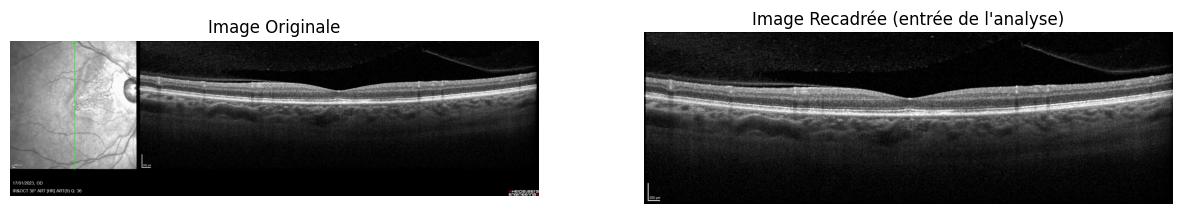

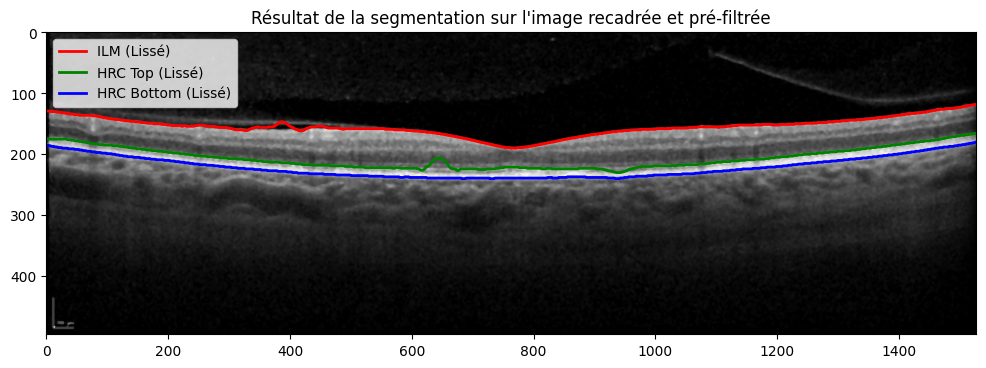

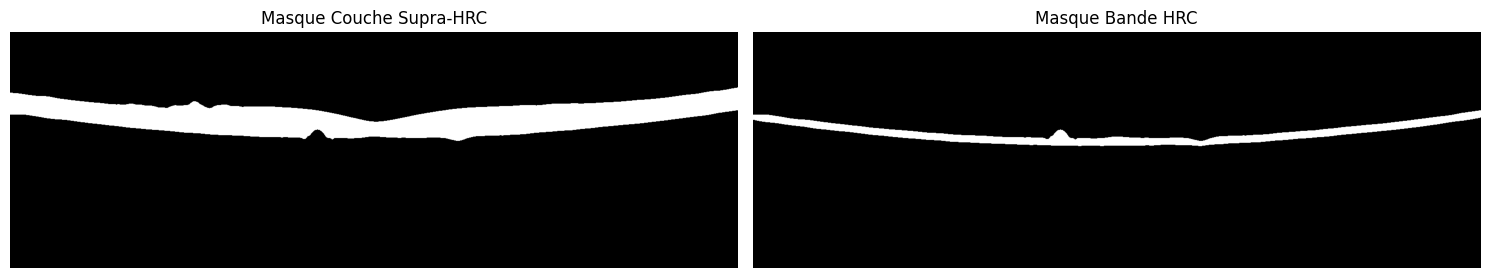

In [213]:
# --- Bloc d'Exécution Principal pour une seule image, avec recadrage ---

# 1. Définir le chemin de l'image ORIGINALE à traiter
image_path_original = r"IMAGES\IMAGES\01_CAB_OD\CAB_OD000.png"

# 2. Définir le répertoire et le nom de base pour les masques de sortie
output_mask_directory = "masques_generes" 
base_filename = os.path.splitext(os.path.basename(image_path_original))[0]

# --- Pipeline de traitement ---

print(f"--- Traitement de l'image : {image_path_original} ---")

# Étape 1: Charger l'image originale
print("Étape 1: Chargement de l'image originale...")
image_original = load_image(image_path_original)

if image_original is not None:
    # Étape 2: Recadrer l'image originale
    # On reproduit la logique de votre fonction crop_bscan pour le x_end
    print("Étape 2: Recadrage de l'image...")
    largeur_originale = image_original.shape[1]
    x_end_dynamique = largeur_originale - 10
    
    image_cropped = crop_image(
        image_original, 
        CROP_X_START, 
        CROP_Y_START, 
        x_end_dynamique, 
        CROP_Y_END
    )

    if image_cropped is not None and image_cropped.size > 0:
        # La suite du pipeline utilise maintenant 'image_cropped'
        
        # Étape 3: Appliquer le pré-filtrage
        print("Étape 3: Application du pré-filtrage...")
        pre_filtre = pre_filtrage(image_cropped)
        
        # Étape 4: Segmenter l'ILM (brut)
        print("Étape 4: Segmentation de l'ILM...")
        ilm_brut = segment_ilm_gradient_based(pre_filtre)
        
        # Étape 5: Segmenter la bande HRC (brut)
        print("Étape 5: Segmentation de la bande HRC...")
        hrc_brut_top, hrc_brut_bottom = segment_hrc_band(pre_filtre, ilm_brut)
        
        # Étape 6: Appliquer le post-filtrage (lissage)
        print("Étape 6: Lissage des lignes détectées...")
        ilm_lisse, hrc_top_lisse, hrc_bot_lisse = post_filtrage(ilm_brut, [hrc_brut_top, hrc_brut_bottom])

        # Étape 7: Créer et sauvegarder les masques
        print(f"Étape 7: Création des masques dans '{output_mask_directory}'...")
        mask_supra, mask_hrc = create_and_save_retinal_layer_masks(
            ilm_line=ilm_lisse,
            hrc_top_line=hrc_top_lisse,
            hrc_bottom_line=hrc_bot_lisse,
            image_shape=pre_filtre.shape,
            output_directory=output_mask_directory,
            base_filename=f"masked_{base_filename}", # Ajout d'un préfixe pour clarté
            debug=True
        )
        print("--- Traitement terminé avec succès ! ---")

    else:
        print("Erreur: Le recadrage de l'image a échoué.")
else:
    print(f"Erreur: L'image originale n'a pas pu être chargée depuis {image_path_original}")

# --- Visualisation complète du pipeline pour une image ---

if 'image_cropped' in locals() and image_cropped is not None:
    
    # Figure 1: Comparaison Originale vs. Recadrée
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))
    plt.title("Image Originale")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
    plt.title("Image Recadrée (entrée de l'analyse)")
    plt.axis('off')
    
    plt.show()

    # Figure 2: Image recadrée avec les lignes superposées
    plt.figure(figsize=(12, 8))
    plt.imshow(pre_filtre, cmap='gray')
    plt.plot(ilm_lisse, 'r-', label='ILM (Lissé)', linewidth=2)
    plt.plot(hrc_top_lisse, 'g-', label='HRC Top (Lissé)', linewidth=2)
    plt.plot(hrc_bot_lisse, 'b-', label='HRC Bottom (Lissé)', linewidth=2)
    plt.title("Résultat de la segmentation sur l'image recadrée et pré-filtrée")
    plt.legend()
    plt.show()

    # Figure 3: Affichage des masques finaux
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(mask_supra, cmap='gray')
    plt.title("Masque Couche Supra-HRC")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_hrc, cmap='gray')
    plt.title("Masque Bande HRC")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

<h2> Méthode n°3 Deep learning ave U-net

Variables pour le deep learning

In [ ]:
UNET_INPUT_SIZE = (256, 256)
NUM_CLASSES = 1 
BATCH_SIZE = 4  
EPOCHS = 20     #test 50
LEARNING_RATE = 0.001
MODEL_SAVE_PATH_ILM = 'ilm_unet.h5'
ROOT_IMG_DIR = OUTPUT_DIR
ROOT_MSK_DIR = './R_BIN1/R_BIN1'
MASK_SUFFIX_ILM = "_BIN1.png"
MASK_BIN1_REPRESENTS_FOR_EXTRACTION = "ILM_BAND"

In [215]:
def dice_coeff(y_true, y_pred, smooth=1e-6):
    ''' fonction de perte '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)


def load_image_mask_for_training(image_path_tensor, mask_path_tensor, image_size=UNET_INPUT_SIZE):
    
    image = tf.io.read_file(image_path_tensor)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32) / 255.0

    # Charger le masque
    mask = tf.io.read_file(mask_path_tensor)
    mask = tf.image.decode_png(mask, channels=1) # Masques binaires sont aussi en niveaux de gris
    mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # NEAREST pour les masques
    mask = tf.cast(mask, tf.float32) / 255.0 # Normaliser le masque (0 ou 1)
    # S'assurer que le masque est bien binaire après resize et cast (certaines interpolations peuvent créer des valeurs intermédiaires)
    mask = tf.cast(mask > 0.5, tf.float32) # Binariser explicitement

    return image, mask

class Augment(tf.keras.layers.Layer): # Hériter de Layer pour l'intégrer dans le pipeline tf.data
    def __init__(self, seed=42):
        super().__init__()
        # Utiliser tf.keras.layers pour les augmentations compatibles avec le graphe TF
        self.flip_left_right = layers.RandomFlip("horizontal", seed=seed)
        self.flip_up_down = layers.RandomFlip("vertical", seed=seed)
        # Brightness et contrast peuvent être plus complexes à intégrer directement dans tf.data de manière simple
        # Pour l'instant, on se concentre sur les flips.
        # Vous pouvez utiliser tf.image.random_brightness, etc., dans une fonction map si besoin.

    def call(self, image, mask):
        # Les augmentations doivent être appliquées de la même manière à l'image et au masque
        # pour les transformations géométriques.
        # Concaténer pour appliquer les flips en même temps (si possible avec les layers Keras)
        # Ou appliquer séquentiellement. Ici, séquentiel.

        # Random horizontal flip
        # Créer un état aléatoire pour que le flip soit le même pour image et mask
        seed_pair = tf.random.experimental.stateless_split(tf.random.get_global_generator().make_seeds(2)[0], num=1)[0]

        image = tf.image.stateless_random_flip_left_right(image, seed=seed_pair)
        mask = tf.image.stateless_random_flip_left_right(mask, seed=seed_pair)

        # Random vertical flip (avec une nouvelle seed_pair)
        seed_pair = tf.random.experimental.stateless_split(tf.random.get_global_generator().make_seeds(2)[0], num=1)[0]
        image = tf.image.stateless_random_flip_up_down(image, seed=seed_pair)
        mask = tf.image.stateless_random_flip_up_down(mask, seed=seed_pair)

        # Random color distortions (image only) - s'assurer que l'image a 3 canaux si nécessaire
        # Si image est (H,W,1), random_brightness/contrast fonctionnent.
        image = tf.image.random_brightness(image, max_delta=0.1)
        # image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # Peut être sensible

        return image, mask


def get_dataset_for_training(image_files, mask_files, image_size=UNET_INPUT_SIZE,
                             batch_size=BATCH_SIZE, shuffle=True, augment=False, repeat=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: load_image_mask_for_training(x, y, image_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_files) // 2 or 100) # Ajuster buffer_size

    dataset = dataset.batch(batch_size)

    if augment:
        dataset = dataset.map(Augment(), num_parallel_calls=tf.data.AUTOTUNE) # Appliquer l'augmentation après le batching ? Non, avant.
        # Correction: l'augmentation est typiquement appliquée par élément avant le batching.
        # Si Augment est un tf.keras.layers.Layer, elle peut être mappée.
        # Pour une version plus simple de Augment, vous pouvez la mapper avant le batch.
        # dataset = dataset.map(Augment(), num_parallel_calls=tf.data.AUTOTUNE) # Si Augment est un tf.keras.Layer
        # Ou si c'est une fonction python simple (avec tf ops):
        # dataset = dataset.map(lambda i,m: augment_fn(i,m), num_parallel_calls=tf.data.AUTOTUNE)

    if repeat: # Utile pour train_dataset
        dataset = dataset.repeat()

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [216]:

# --- Définition du Modèle U-Net (votre code) ---
def unet_model(input_shape=(UNET_INPUT_SIZE[0], UNET_INPUT_SIZE[1], 1), num_classes=NUM_CLASSES):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck (c4 dans votre code TD, ici je continue la numérotation)
    c4_bottle = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4_bottle = layers.Dropout(0.2)(c4_bottle)
    c4_bottle = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4_bottle)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4_bottle)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u5)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = layers.Dropout(0.1)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1], axis=3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c7) # Sigmoid pour binaire

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# --- Fonctions de Test/Prédiction ---

In [217]:

def preprocess_for_unet_inference(image_np, target_size=UNET_INPUT_SIZE):
    if len(image_np.shape) == 3 and image_np.shape[-1] == 3: img_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    elif len(image_np.shape) == 2: img_gray = image_np
    else: raise ValueError("Format d'image non supporté.")
    img_resized = cv2.resize(img_gray, target_size, interpolation=cv2.INTER_AREA)
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_tensor = img_normalized[np.newaxis, ..., np.newaxis]
    return tf.convert_to_tensor(img_tensor)

def predict_single_mask_with_unet(bscan_image_np, loaded_model, threshold=0.5):
    if loaded_model is None: return None
    original_size = (bscan_image_np.shape[1], bscan_image_np.shape[0]) # W, H
    target_model_size = (loaded_model.input_shape[2], loaded_model.input_shape[1]) # W, H for cv2.resize
    input_tensor = preprocess_for_unet_inference(bscan_image_np, target_size=target_model_size)
    pred_prob_map = loaded_model.predict(input_tensor)
    pred_prob_map_squeezed = np.squeeze(pred_prob_map)
    binary_mask_unet_size = (pred_prob_map_squeezed > threshold).astype(np.uint8)
    binary_mask_original_size = cv2.resize(binary_mask_unet_size, original_size, interpolation=cv2.INTER_NEAREST)
    return binary_mask_original_size

fonction principale

In [ ]:
def run_ilm_training_and_testing(
    root_img_dir, root_msk_dir,
    train_patient_folder_names, val_patient_folder_names,
    mask_suffix_for_ilm, model_save_name,
    unet_input_size, batch_size, epochs, learning_rate
):
    train_img_paths, train_mask_paths, val_img_paths, val_mask_paths = [], [], [], []

    print(f"\nCollecte des fichiers pour l'entraînement ILM (masque suffixe: {mask_suffix_for_ilm})...")
    for folder_name in train_patient_folder_names:
        current_img_folder = os.path.join(root_img_dir, folder_name)
        
        current_mask_folder = os.path.join(root_msk_dir, folder_name)
        print('current folder',current_img_folder,current_mask_folder)
        if not (os.path.isdir(current_img_folder) and os.path.isdir(current_mask_folder)): continue
        print('passage')
        images_in_folder = sorted(glob.glob(os.path.join(current_img_folder, "*.png"))) 
        for img_path in images_in_folder:
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            mask_path = os.path.join(current_mask_folder, f"{base_name}{mask_suffix_for_ilm}")
            if os.path.exists(mask_path):
                train_img_paths.append(img_path); train_mask_paths.append(mask_path)



    print(f"Collecte des fichiers pour la validation ILM (masque suffixe: {mask_suffix_for_ilm})...")
    for folder_name in val_patient_folder_names:
        current_img_folder = os.path.join(root_img_dir, folder_name)
        current_mask_folder = os.path.join(root_msk_dir, folder_name)
        if not (os.path.isdir(current_img_folder) and os.path.isdir(current_mask_folder)): continue
        images_in_folder = sorted(glob.glob(os.path.join(current_img_folder, "*.png"))) 
        for img_path in images_in_folder:
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            mask_path = os.path.join(current_mask_folder, f"{base_name}{mask_suffix_for_ilm}")
            if os.path.exists(mask_path):
                val_img_paths.append(img_path); val_mask_paths.append(mask_path)



    print(train_img_paths,val_img_paths)
    if not train_img_paths or not val_img_paths:
        print("Erreur: Pas assez de données d'entraînement ou de validation pour ILM. Arrêt.")
        return None

    print(f"\nEntraînement pour {model_save_name}:")
    print(f"  Images d'entraînement ILM: {len(train_img_paths)}, Images de validation ILM: {len(val_img_paths)}")

    train_ds = get_dataset_for_training(train_img_paths, train_mask_paths, image_size=unet_input_size,
                                      batch_size=batch_size, shuffle=True, augment=True, repeat=True)
    val_ds = get_dataset_for_training(val_img_paths, val_mask_paths, image_size=unet_input_size,
                                    batch_size=batch_size, shuffle=False, augment=False, repeat=False)

    for image_batch, mask_batch in train_ds.take(1):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1); plt.imshow(tf.squeeze(image_batch[0]).numpy(), cmap='gray'); plt.title("Ex. Image ILM Train"); plt.axis('off')
        plt.subplot(1, 2, 2); plt.imshow(tf.squeeze(mask_batch[0]).numpy(), cmap='gray'); plt.title("Ex. Masque ILM Train"); plt.axis('off')
        plt.show()
        break

    model = unet_model(input_shape=(unet_input_size[0], unet_input_size[1], 1), num_classes=1)
    try: optimizer = Adam(learning_rate=learning_rate)
    except TypeError: optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coeff, 'accuracy'])
    if len(train_img_paths) < 20 : model.summary()

    steps_per_epoch = len(train_img_paths) // batch_size
    if steps_per_epoch == 0: steps_per_epoch = 1
    print(f"  Début de l'entraînement ILM ({epochs} époques, {steps_per_epoch} steps/epoch)...")
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds)

    model.save(model_save_name)
    print(f"  Modèle ILM entraîné sauvegardé à : {model_save_name}")

    # --- Section Test pour ILM ---
    print(f"\n--- Test du Modèle ILM : {model_save_name} ---")
    trained_unet_ilm = load_model(model_save_name, custom_objects={'dice_loss': dice_loss, 'dice_coeff': dice_coeff})
    num_test_images_to_show = min(3, len(val_img_paths))
    for i in range(num_test_images_to_show):
        test_image_path = val_img_paths[i]
        true_mask_path = val_mask_paths[i]
        bscan_np_for_pred = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
        if bscan_np_for_pred is None: continue

        predicted_mask = predict_single_mask_with_unet(bscan_np_for_pred, trained_unet_ilm)
        true_mask_np = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
        # Resize true_mask_np to bscan_np_for_pred shape for consistent display
        if true_mask_np is not None and true_mask_np.shape != bscan_np_for_pred.shape[:2]:
            true_mask_np = cv2.resize(true_mask_np, (bscan_np_for_pred.shape[1], bscan_np_for_pred.shape[0]), interpolation=cv2.INTER_NEAREST)


        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(bscan_np_for_pred, cmap='gray')
        plt.title(f"Image Test ILM"); plt.axis('off')
        plt.subplot(1, 3, 2)
        if true_mask_np is not None: plt.imshow(true_mask_np, cmap='gray')
        plt.title("Vrai Masque ILM")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        if predicted_mask is not None: plt.imshow(predicted_mask, cmap='gray')
        plt.title("Préd. Masque ILM")
        plt.axis('off')
        plt.suptitle(f"Test ILM pour {os.path.basename(test_image_path)}")
        plt.tight_layout(rect=[0,0,1,0.93])
        plt.show()
    return model_save_name

Dossiers pour entraînement: ['01_CAB_OD', '02_DEA_OD', '03_DEA_OS', '04_BIM_OD', '05_MIG_OD', '06_MIG_OS', '07_TIM_OD']
Dossiers pour validation: ['08_TRK_OD']

========================= ENTRAÎNEMENT ET TEST MODÈLE ILM =========================

Collecte des fichiers pour l'entraînement ILM (masque suffixe: _BIN1.png)...
current folder ./OUTPUT_CROPPED\01_CAB_OD ./R_BIN1/R_BIN1\01_CAB_OD
passage
current folder ./OUTPUT_CROPPED\02_DEA_OD ./R_BIN1/R_BIN1\02_DEA_OD
passage
current folder ./OUTPUT_CROPPED\03_DEA_OS ./R_BIN1/R_BIN1\03_DEA_OS
passage
current folder ./OUTPUT_CROPPED\04_BIM_OD ./R_BIN1/R_BIN1\04_BIM_OD
passage
current folder ./OUTPUT_CROPPED\05_MIG_OD ./R_BIN1/R_BIN1\05_MIG_OD
passage
current folder ./OUTPUT_CROPPED\06_MIG_OS ./R_BIN1/R_BIN1\06_MIG_OS
passage
current folder ./OUTPUT_CROPPED\07_TIM_OD ./R_BIN1/R_BIN1\07_TIM_OD
passage
Collecte des fichiers pour la validation ILM (masque suffixe: _BIN1.png)...
['./OUTPUT_CROPPED\\01_CAB_OD\\CAB_OD000.png', './OUTPUT_CROPPED\\01_

c:\TRAVAIL\A2\Vision par ordinateur\env_vision_ordi\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning:

`build()` was called on layer 'augment', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.



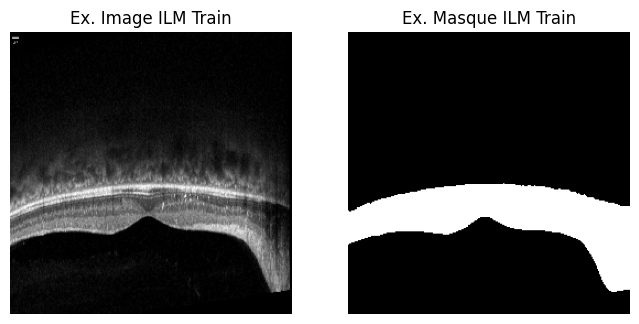

  Début de l'entraînement ILM (20 époques, 72 steps/epoch)...
Epoch 1/20


c:\TRAVAIL\A2\Vision par ordinateur\env_vision_ordi\Lib\site-packages\keras\src\models\functional.py:238: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2']
Received: inputs=Tensor(shape=(None, 256, 256, 1))



72/72 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.5090 - dice_coeff: 0.3799 - loss: 0.6201 - val_accuracy: 0.8496 - val_dice_coeff: 2.5363e-11 - val_loss: 1.0000
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8481 - dice_coeff: 2.5178e-11 - loss: 1.0000 - val_accuracy: 0.8496 - val_dice_coeff: 2.5363e-11 - val_loss: 1.0000
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8465 - dice_coeff: 2.4890e-11 - loss: 1.0000 - val_accuracy: 0.8496 - val_dice_coeff: 2.5363e-11 - val_loss: 1.0000
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8480 - dice_coeff: 2.5139e-11 - loss: 1.0000 - val_accuracy: 0.8496 - val_dice_coeff: 2.5363e-11 - val_loss: 1.0000
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8471 - dice_coeff: 2.4972e-11 - loss: 1.0000 - val_accuracy: 0.8496 - val_dice_coeff: 2.5363e-11 - val_loss: 1.0000
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8487 - dice_coeff: 2.5253e-11 - loss: 1.0000 

In [ ]:
try:
    all_patient_subfolders = [d for d in os.listdir(ROOT_IMG_DIR) if os.path.isdir(os.path.join(ROOT_IMG_DIR, d))]
    all_patient_subfolders.sort()
    if not all_patient_subfolders:
        raise FileNotFoundError("Aucun sous-dossier trouvé dans ROOT_IMG_DIR")
except FileNotFoundError as e:
    print(f"Erreur: {e}. Vérifiez le chemin ROOT_IMG_DIR: '{ROOT_IMG_DIR}'")
    exit()


if len(all_patient_subfolders) >= 2:
    num_val_folders = max(1, len(all_patient_subfolders) // 5) # ~20% pour la validation
    num_train_folders = len(all_patient_subfolders) - num_val_folders
    
    train_folders = all_patient_subfolders[:num_train_folders]
    val_folders   = all_patient_subfolders[num_train_folders:]
    
    # S'assurer que val_folders n'est pas vide si train_folders ne l'est pas
    if not val_folders and train_folders:
        val_folders = [train_folders[-1]] # Prendre le dernier de train pour val
        if len(train_folders) > 1 : # S'assurer qu'il reste qqch pour train
                train_folders = train_folders[:-1]
        else: # Si train n'avait qu'un dossier, et qu'on le met en val, train devient vide.
                # Dans ce cas, il vaut mieux dupliquer pour test, ou erreur.
                print("Attention: Pas assez de dossiers distincts pour un split train/val propre. Utilisation du même dossier pour val.")


    print(f"Dossiers pour entraînement: {train_folders}")
    print(f"Dossiers pour validation: {val_folders}")
elif len(all_patient_subfolders) == 1:
    print("Attention: Un seul dossier de patient trouvé. Utilisation pour train ET validation.")
    train_folders = all_patient_subfolders
    val_folders = all_patient_subfolders
else:
    print(f"Pas assez de dossiers de patients ({len(all_patient_subfolders)}) dans {ROOT_IMG_DIR} pour diviser en train/val. Arrêt.")
    exit()

if not train_folders : # S'assurer que train_folders n'est pas vide
    print(f"Aucun dossier d'entraînement défini après le split. Arrêt.")
    exit()


# --- Entraînement et test pour ILM (_BIN1) ---
print("\n" + "="*25 + " ENTRAÎNEMENT ET TEST MODÈLE ILM " + "="*25)
trained_ilm_model_path = run_ilm_training_and_testing(
    root_img_dir=ROOT_IMG_DIR,
    root_msk_dir=ROOT_MSK_DIR,
    train_patient_folder_names=train_folders,
    val_patient_folder_names=val_folders,
    mask_suffix_for_ilm=MASK_SUFFIX_ILM,
    model_save_name=MODEL_SAVE_PATH_ILM,
    unet_input_size=UNET_INPUT_SIZE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE
)

if trained_ilm_model_path:
    print(f"\nEntraînement du modèle ILM terminé. Modèle sauvegardé à : {trained_ilm_model_path}")
    print("Vous pouvez maintenant intégrer ce modèle dans votre pipeline de segmentation principal.")
else:
    print("\nL'entraînement du modèle ILM a échoué ou a été sauté.")


In [ ]:
trained_ilm_model_path = run_ilm_training_and_testing(
    root_img_dir=ROOT_IMG_DIR,
    root_msk_dir=ROOT_MSK_DIR,
    train_patient_folder_names=train_folders,
    val_patient_folder_names=val_folders,
    mask_suffix_for_ilm=MASK_SUFFIX_ILM,
    model_save_name='ilm_50_unet.h5',
    unet_input_size=(512, 512),
    batch_size=BATCH_SIZE,
    epochs=50,
    learning_rate=LEARNING_RATE
)

<h1>Recalage

In [ ]:
def find_fovea_center(ilm_curve):
    """Trouve le point le plus bas de la fovéa (coordonnée Y maximale)."""
    if ilm_curve is None or len(ilm_curve) == 0:
        return None, None
    x_fovea = np.argmax(ilm_curve)
    y_fovea = ilm_curve[x_fovea]
    return (x_fovea, y_fovea)

def translate_image(image, dx, dy):
    """Applique une translation (dx, dy) à une image."""
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    # On remplit les bords en noir pour un rendu propre
    translated = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    return translated

# --- Fonction Principale de la Pipeline ---

def process_patient_series(patient_directory, output_gif_path="recalage_final.gif",debug=False):
    """
    Exécute la pipeline complète : segmentation, calcul des décalages, recalage,
    génération d'un graphe de contrôle et création d'un GIF animé.
    """
    if debug: print(f"--- Lancement de la pipeline pour le dossier : {patient_directory} ---")
    
    # 1. Lister et trier les images pour garantir l'ordre angulaire
    image_files = sorted([
        os.path.join(patient_directory, f) 
        for f in os.listdir(patient_directory) 
        if f.lower().endswith(('.png', '.tif', '.jpg'))
    ])
    if not image_files:
        if debug: print("Erreur : Aucun fichier image trouvé.")
        return

    # =================================================================
    # PHASE 1 : ANALYSE ET COLLECTE DES DONNÉES (IMAGE PAR IMAGE)
    # =================================================================
    if debug: print("\n--- PHASE 1: Analyse et Segmentation de chaque B-Scan ---")
    analysis_data = [] # Pour stocker les résultats de chaque image
    for i, image_path in enumerate(image_files):
        if debug: print(f"  Analyse de l'image {os.path.basename(image_path)} ({i+1}/{len(image_files)})...")
        
        # a. Charger et recadrer
        img_orig = load_image(image_path)
        if img_orig is None: continue
        x_end = img_orig.shape[1] - 10
        img_cropped = crop_image(img_orig, CROP_X_START, CROP_Y_START, x_end, CROP_Y_END)
        if img_cropped is None: continue
        
        # b. Segmenter pour trouver la courbe ILM
        pre_filtre = pre_filtrage(img_cropped)
        ilm_brut = segment_ilm_gradient_based(pre_filtre)
        hrc_brut = segment_hrc_band(pre_filtre, ilm_brut)
        ilm_lisse, hrc_top_lisse, hrc_bot_lisse = post_filtrage(ilm_brut, hrc_brut)
        
        # c. Trouver le point de référence (centre de la fovéa) sur cette courbe
        fovea_center_x, fovea_center_y = find_fovea_center(ilm_lisse)
        
        # d. Stocker toutes les informations utiles
        analysis_data.append({
            "cropped_image": img_cropped.copy(), # On stocke une copie de l'image recadrée
            "ilm_curve": ilm_lisse,
            "hrc_top_curve": hrc_top_lisse,
            "fovea_center": (fovea_center_x, fovea_center_y)
        })
    
    # =================================================================
    # PHASE 2 : RECALAGE, VISUALISATION ET GÉNÉRATION DES LIVRABLES
    # =================================================================
    if debug: print("\n--- PHASE 2: Recalage et Génération des résultats ---")
    
    if not analysis_data:
        if debug: print("Aucune image n'a pu être analysée.")
        return

    # --- Étape 2a : Calcul des décalages ---
    # Le point de référence est le centre de la fovéa de la PREMIÈRE image
    x_ref, y_ref = analysis_data[0]["fovea_center"]
    if debug: print(f"Point de référence pour l'alignement : (x={x_ref}, y={y_ref})")

    images_for_gif = []
    recalibrated_images = [] # Pour la visualisation de contrôle

    for data in analysis_data:
        x_i, y_i = data["fovea_center"]
        dx = x_ref - x_i
        dy = y_ref - y_i

        # Préparation de l'image pour le GIF : on dessine AVANT de translater
        img_to_draw = data["cropped_image"]
        # Dessin de l'ILM en rouge
        for x in range(len(data["ilm_curve"]) - 1):
            pt1 = (x, data["ilm_curve"][x])
            pt2 = (x + 1, data["ilm_curve"][x + 1])
            cv2.line(img_to_draw, pt1, pt2, (0, 0, 255), 2)
        # Dessin du HRC en vert
        for x in range(len(data["hrc_top_curve"]) - 1):
             pt1 = (x, data["hrc_top_curve"][x])
             pt2 = (x + 1, data["hrc_top_curve"][x + 1])
             cv2.line(img_to_draw, pt1, pt2, (0, 255, 0), 1)

        # On translate l'image qui contient déjà les dessins
        recal_img_with_lines = translate_image(img_to_draw, dx, dy)
        recalibrated_images.append(recal_img_with_lines) # On garde la version BGR pour le composite
        
        # Conversion pour le GIF
        images_for_gif.append(cv2.cvtColor(recal_img_with_lines, cv2.COLOR_BGR2RGB))
        
    # --- Étape 2b : Outil de visualisation de contrôle ---
    if debug: print("Génération du graphe de contrôle du recalage (superposition)...")
    
    # On crée une image de fond en faisant la moyenne de toutes les images recalées
    # Cela permet de voir si les structures s'alignent bien (elles deviendront plus nettes)
    composite_image = np.mean(recalibrated_images, axis=0).astype(np.uint8)
    composite_image_rgb = cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))
    plt.imshow(composite_image_rgb)
    # On dessine une croix sur le point de référence pour vérifier l'alignement
    plt.axvline(x=x_ref, color='yellow', linestyle='--', label=f'Centre X aligné ({x_ref}px)')
    plt.axhline(y=y_ref, color='yellow', linestyle='--', label=f'Centre Y aligné ({y_ref}px)')
    plt.title("Contrôle Visuel du Recalage\n(Superposition de toutes les images après alignement)")
    plt.legend()
    plt.show()

    # --- Étape 2c : Création du GIF animé ---
    if debug: print(f"Création du GIF animé : {output_gif_path}...")
    imageio.mimsave(output_gif_path, images_for_gif, fps=5)
    if debug: print(f"--- Pipeline terminée. GIF sauvegardé : '{output_gif_path}' ---")

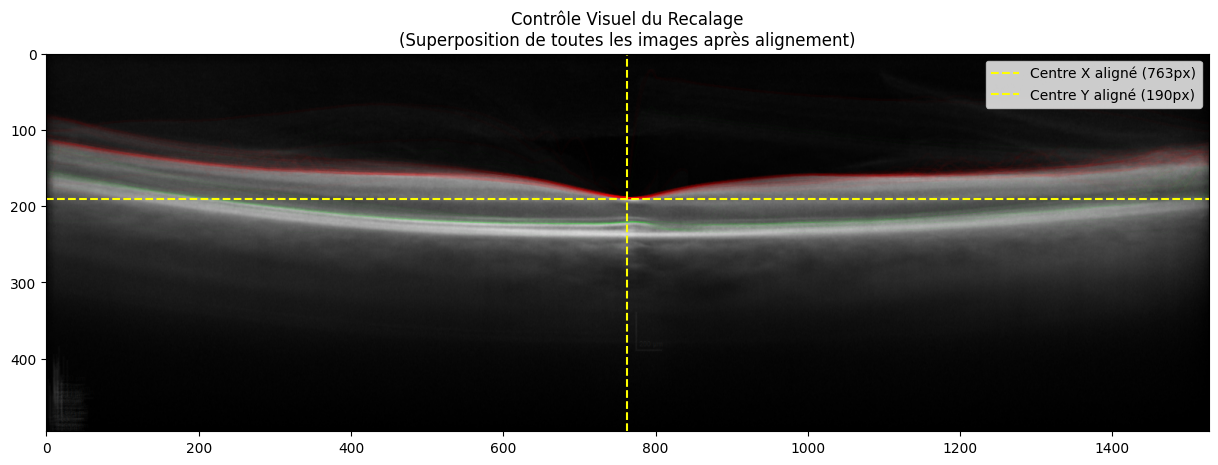

In [ ]:
# --- Point d'entrée pour lancer toute la pipeline sur un patient ---

base_images_folder = r"IMAGES\IMAGES"
patient_subfolder = "01_CAB_OD" 

# --- Lancement ---
dossier_patient = os.path.join(base_images_folder, patient_subfolder)

if os.path.isdir(dossier_patient):
    process_patient_series(dossier_patient)
else:
    print(f"ERREUR : Le dossier patient n'a pas été trouvé à l'emplacement : {dossier_patient}")

In [ ]:
# ==============================================================================
#                 PIPELINE COMPLÈTE AVEC GRAPHE 3D INTERACTIF (PLOTLY)
# ==============================================================================


def process_and_reconstruct_3d(patient_directory, CROP_X_START, CROP_Y_START, CROP_Y_END,debug=False):
    if debug: print(f"--- Lancement de la pipeline complète pour : {patient_directory} ---")
    
    image_files = sorted([os.path.join(patient_directory, f) for f in os.listdir(patient_directory) if f.lower().endswith(('.png', '.tif'))])
    if not image_files: return

    # PHASE 1 : Analyse et collecte des données
    if debug: print("\n--- PHASE 1: Analyse et Segmentation ---")
    analysis_data = []
    for i, image_path in enumerate(image_files):
        if debug: print(f"  Analyse de l'image {os.path.basename(image_path)} ({i+1}/{len(image_files)})...")
        img_orig = load_image(image_path)
        if img_orig is None: continue
        x_end = img_orig.shape[1] - 10
        img_cropped = crop_image(img_orig, CROP_X_START, CROP_Y_START, x_end, CROP_Y_END)
        if img_cropped is None: continue
        pre_filtre = pre_filtrage(img_cropped)
        ilm_brut = segment_ilm_gradient_based(pre_filtre)
        hrc_brut_top, hrc_brut_bottom = segment_hrc_band(pre_filtre, ilm_brut)
        ilm_lisse, _, _ = post_filtrage(ilm_brut, [hrc_brut_top, hrc_brut_bottom])
        fovea_center_x, fovea_center_y = find_fovea_center(ilm_lisse)
        analysis_data.append({"ilm_curve": ilm_lisse, "fovea_center": (fovea_center_x, fovea_center_y)})
    
    if len(analysis_data) < 2: return

    # PHASE 2 : Calcul du point de référence
    if debug: print("\n--- PHASE 2: Calcul du point de référence ---")
    x_ref, y_ref = analysis_data[0]["fovea_center"]
    
    # PHASE 3 : Reconstruction 3D avec recalage fin
    if debug: print("\n--- PHASE 3: Reconstruction 3D ---")
    all_points_3d = []
    angle_step = 180.0 / len(analysis_data)

    for i, data in enumerate(analysis_data):
        angle_rad = np.deg2rad(i * angle_step)
        ilm_curve = data["ilm_curve"]
        x_fovea_current, y_fovea_current = data["fovea_center"]

        x_coords_2d = np.arange(len(ilm_curve))
        
        rayon_recalibre = x_coords_2d - x_fovea_current
        
        X = rayon_recalibre * np.cos(angle_rad)
        Y = rayon_recalibre * np.sin(angle_rad)
        
        Z = ilm_curve - y_fovea_current # On utilise ilm_curve
        
        all_points_3d.append(np.vstack((X, Y, Z)).T)
        
    if not all_points_3d: return
        
    points_3d_array = np.concatenate(all_points_3d, axis=0)
    X_points, Y_points, Z_points = points_3d_array[:, 0], points_3d_array[:, 1], points_3d_array[:, 2]

    # répartitions des points en axe X,Y sur 150 points équidistants entre les min et max    
    grid_x, grid_y = np.mgrid[min(X_points):max(X_points):150j, min(Y_points):max(Y_points):150j]
    grid_z = griddata((X_points, Y_points), Z_points, (grid_x, grid_y), method='cubic')
    
    
    if debug: print("\n--- Génération du graphe 3D interactif avec Plotly ---")
    fig = go.Figure(data=[go.Surface(z=grid_z, x=grid_x, y=grid_y, colorscale='Viridis', reversescale=True)])
    fig.update_layout(
        title='Reconstruction 3D Interactive (après recalage et lissage)',
        scene=dict(
            xaxis_title='Axe X (pixels)', yaxis_title='Axe Y (pixels)', zaxis_title='Profondeur Relative Z (pixels)',
            zaxis=dict(autorange="reversed"), aspectratio=dict(x=1, y=1, z=0.4)
        ),
        width=800, height=700, margin=dict(r=20, b=10, l=10, t=40)
    )
    fig.show()



In [ ]:
base_images_folder = r"IMAGES\IMAGES"
patient_subfolder = "01_CAB_OD" 
dossier_patient = os.path.join(base_images_folder, patient_subfolder)
if os.path.isdir(dossier_patient):
    process_and_reconstruct_3d(dossier_patient, CROP_X_START, CROP_Y_START, CROP_Y_END)
else:
    print(f"ERREUR : Le dossier patient n'a pas été trouvé : {dossier_patient}")

<h2> Image 3D sur images non recadrées

In [ ]:

def reconstruct_and_visualize_3d(patient_directory,debug=False):
    """
    Traite toutes les images d'un patient, reconstruit la surface de l'ILM en 3D
    et la visualise.
    """
    
    if debug: print(f"--- Démarrage de la reconstruction 3D pour le dossier : {patient_directory} ---")
    
    all_points_3d = []
    
    # os.path.join est utilisé pour construire les chemins de manière fiable
    image_files = sorted([
        os.path.join(patient_directory, f) 
        for f in os.listdir(patient_directory) 
        if f.lower().endswith(('.png', '.tif', '.jpg'))
    ])
    
    if not image_files:
        if debug: print("Aucune image trouvée dans le dossier.")
        return
        
    angle_step = 180.0 / len(image_files)
    
    for i, image_path in enumerate(image_files):
        angle_rad = np.deg2rad(i * angle_step)
        if debug: print(f"  Traitement de l'image {i+1}/{len(image_files)} (Angle: {i * angle_step:.1f}°)...")

        image_original = load_image(image_path)
        if image_original is None:
            # L'erreur que vous voyiez se produisait ici. On continue pour ne pas bloquer le script.
            if debug: print(f"  Erreur : Impossible de charger l'image à {image_path}")
            continue
            
        x_end_dynamique = image_original.shape[1] - 10
        image_cropped = crop_image(image_original, CROP_X_START, CROP_Y_START, x_end_dynamique, CROP_Y_END)
        if image_cropped is None:
            continue
            
        pre_filtre = pre_filtrage(image_cropped)
        ilm_brut = segment_ilm_gradient_based(pre_filtre)
        hrc_brut = segment_hrc_band(pre_filtre, ilm_brut)
        ilm_lisse, _, _ = post_filtrage(ilm_brut, hrc_brut)
        
        largeur = len(ilm_lisse)
        x_coords_2d = np.arange(largeur)
        y_coords_2d = ilm_lisse
        
        rayon = x_coords_2d - (largeur / 2)
        
        X = rayon * np.cos(angle_rad)
        Y = rayon * np.sin(angle_rad)
        Z = y_coords_2d
        
        points_scan = np.vstack((X, Y, Z)).T
        all_points_3d.append(points_scan)

    if not all_points_3d:
        if debug: print("Aucun point 3D n'a pu être généré. Vérifiez les erreurs de chargement d'image.")
        return

    points_3d_array = np.concatenate(all_points_3d, axis=0)
    
    X_points = points_3d_array[:, 0]
    Y_points = points_3d_array[:, 1]
    Z_points = points_3d_array[:, 2]

    if debug: print("Création de la visualisation 3D...")
    
    grid_x, grid_y = np.mgrid[min(X_points):max(X_points):100j, min(Y_points):max(Y_points):100j]
    grid_z = griddata((X_points, Y_points), Z_points, (grid_x, grid_y), method='cubic')

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', edgecolor='none')
    ax.invert_zaxis()
    
    ax.set_title("Reconstruction 3D de la Dépression Fovéolaire (ILM)")
    ax.set_xlabel("Axe X (pixels)")
    ax.set_ylabel("Axe Y (pixels)")
    ax.set_zlabel("Profondeur Z (pixels)")
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()

In [ ]:
# --- Point d'entrée pour la reconstruction 3D d'un patient (version corrigée) ---

# Le chemin de base contenant tous les dossiers de patients (défini dans votre cellule 5)
base_images_folder = IMAGE_DIR 

# Le nom du sous-dossier spécifique du patient que vous voulez analyser
patient_subfolder = "01_CAB_OD" 

# On utilise os.path.join pour construire le chemin complet.
# C'est la méthode la plus sûre pour éviter les problèmes de séparateurs ('\' vs '/').
dossier_patient = os.path.join(base_images_folder, patient_subfolder)

# Vérifions que le dossier existe bien
if os.path.isdir(dossier_patient):
    # Lancer la reconstruction et la visualisation
    reconstruct_and_visualize_3d(dossier_patient)
else:
    print(f"ERREUR : Le dossier patient n'a pas été trouvé à l'emplacement : {dossier_patient}")
    print("Veuillez vérifier les variables 'IMAGE_DIR' et 'patient_subfolder'.")

KeyboardInterrupt: 

Utilisation des vérités terrains

In [ ]:
# ==============================================================================
#                 PARTIE 3 : RECONSTRUCTION 3D DE LA VÉRITÉ TERRAIN
# ==============================================================================

# --- FONCTION UTILITAIRE 1 : Extraire la courbe ILM d'un masque ---
# Cette fonction est cruciale. Elle prend un masque de la couche supérieure
# et trouve, pour chaque colonne, le premier pixel de la couche, qui correspond à l'ILM.

def load_ilm_from_mask(mask_path:str,debug:bool=False):
    """
    Charge un masque binaire et extrait la courbe de l'ILM.
    L'ILM est supposée être la première ligne non-nulle en partant du haut pour chaque colonne.
    
    Args:
        mask_path (str): Le chemin vers une image de masque binaire.
        
    Returns:
        np.array: Un tableau 1D des coordonnées Y de la courbe ILM, ou None si erreur.
    """
    # On charge le masque en niveaux de gris. C'est plus efficace que la couleur.
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        if debug: print(f"  Avertissement : Impossible de charger le masque à {mask_path}")
        return None

    # On s'assure que l'image est bien binaire (0 ou 255) au cas où elle contiendrait des nuances de gris.
    _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    height, width = mask_binary.shape
    ilm_curve = np.zeros(width, dtype=int)
    
    # On parcourt chaque colonne verticale de l'image
    for x in range(width):
        # On récupère tous les pixels de la colonne
        column = mask_binary[:, x]
        # On cherche les indices (coordonnées Y) des pixels qui ne sont pas noirs (valeur > 0)
        non_zero_indices = np.where(column > 0)[0]
        
        if len(non_zero_indices) > 0:
            # L'ILM est le premier pixel blanc que l'on trouve en descendant la colonne.
            # C'est donc l'indice le plus petit.
            ilm_curve[x] = non_zero_indices[0]
        else:
            # Sécurité : si une colonne est entièrement noire, on prend la valeur de la colonne précédente.
            # Cela ne devrait pas se produire avec une vérité terrain de qualité.
            if x > 0:
                ilm_curve[x] = ilm_curve[x-1]
            else:
                ilm_curve[x] = height // 2 # Valeur par défaut si la toute première colonne est vide.
                
    return ilm_curve

# --- FONCTION PRINCIPALE 2 : Reconstruire et visualiser en 3D ---

def reconstruct_3d_from_ground_truth(ground_truth_directory:str, debug:bool=False):
    """
    Reconstruit la surface 3D de l'ILM à partir d'un dossier de masques de vérité terrain
    et affiche le résultat.
    
    Args:
        ground_truth_directory (str): Le chemin vers le dossier contenant les masques parfaits.
    """
    if debug:print(f"--- Lancement de la reconstruction 3D 'parfaite' depuis : {ground_truth_directory} ---")
    
    # Cette liste va contenir tous les points 3D de toutes les images
    all_points_3d = []
    
    # On liste tous les fichiers de masques et on les trie par ordre alphabétique.
    # Le tri est TRES IMPORTANT pour que les angles soient dans le bon ordre (0°, 15°, 30°...).
    mask_files = sorted([
        os.path.join(ground_truth_directory, f) 
        for f in os.listdir(ground_truth_directory) 
        if f.lower().endswith(('.png', '.tif', '.jpg'))
    ])
    
    if not mask_files:
        if debug: print("Erreur : Aucun fichier de masque trouvé dans le dossier spécifié.")
        return

    # L'acquisition en étoile est souvent sur 180°, puis symétrisée.
    # On calcule le pas angulaire en divisant 180 par le nombre de coupes.
    angle_step = 180.0 / len(mask_files)
    
    # On boucle sur chaque fichier de masque
    for i, mask_path in enumerate(mask_files):
        # On calcule l'angle de la coupe actuelle en radians (nécessaire pour cos/sin)
        angle_rad = np.deg2rad(i * angle_step)
        if debug: print(f"  Traitement du masque {i+1}/{len(mask_files)} (Angle: {i * angle_step:.1f}°)...")

        # On utilise notre fonction utilitaire pour obtenir la courbe ILM parfaite
        ilm_curve = load_ilm_from_mask(mask_path)
        
        if ilm_curve is None:
            continue # On passe au masque suivant en cas d'erreur de chargement
            
        # --- Transformation des coordonnées 2D -> 3D ---
        largeur = len(ilm_curve)
        x_coords_2d = np.arange(largeur) # Coordonnées x de la courbe (0, 1, 2, ...)
        y_coords_2d = ilm_curve          # Coordonnées y de la courbe (hauteur)
        
        # Le "rayon" (distance au centre) est la coordonnée x par rapport au milieu de l'image.
        rayon = x_coords_2d - (largeur / 2)
        
        # Conversion des coordonnées polaires (rayon, angle) en coordonnées cartésiennes (X, Y)
        X = rayon * np.cos(angle_rad)
        Y = rayon * np.sin(angle_rad)
        Z = y_coords_2d  # La hauteur/profondeur Z est simplement la coordonnée y de la courbe
        
        # On rassemble les points (X, Y, Z) et on les ajoute à notre liste globale
        points_scan = np.vstack((X, Y, Z)).T
        all_points_3d.append(points_scan)
        
    if not all_points_3d:
        if debug: print("Erreur : Aucun point 3D n'a pu être généré.")
        return

    # On fusionne les listes de points de tous les scans en un seul grand tableau
    points_3d_array = np.concatenate(all_points_3d, axis=0)
    
    X_points = points_3d_array[:, 0]
    Y_points = points_3d_array[:, 1]
    Z_points = points_3d_array[:, 2]

    # --- Visualisation 3D ---
    if debug: print("Création de la visualisation 3D...")
    
    # Pour créer une surface lisse, on définit une grille régulière sur laquelle on va interpoler nos points.
    # 100j signifie qu'on veut 100 points le long de cet axe.
    grid_x, grid_y = np.mgrid[min(X_points):max(X_points):100j, min(Y_points):max(Y_points):100j]
    
    # C'est l'étape clé : 'griddata' calcule la hauteur (Z) sur la grille lisse à partir du nuage de points désordonné.
    # La méthode 'cubic' donne un rendu visuel plus agréable que 'linear'.
    grid_z = griddata((X_points, Y_points), Z_points, (grid_x, grid_y), method='cubic')

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # On dessine la surface. 'cmap' est la palette de couleurs.
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', edgecolor='none')
    
    # Dans les images, l'axe Y (notre Z ici) est inversé (0 est en haut). On fait de même pour un rendu intuitif.
    ax.invert_zaxis() 
    
    # On ajoute les titres et légendes pour un graphe propre
    ax.set_title("Reconstruction 3D 'Parfaite' depuis la Vérité Terrain (ILM)")
    ax.set_xlabel("Axe X (pixels)")
    ax.set_ylabel("Axe Y (pixels)")
    ax.set_zlabel("Profondeur Z (pixels)")
    fig.colorbar(surf, shrink=0.5, aspect=5, label='Profondeur Z (pixels)')
    
    plt.show()

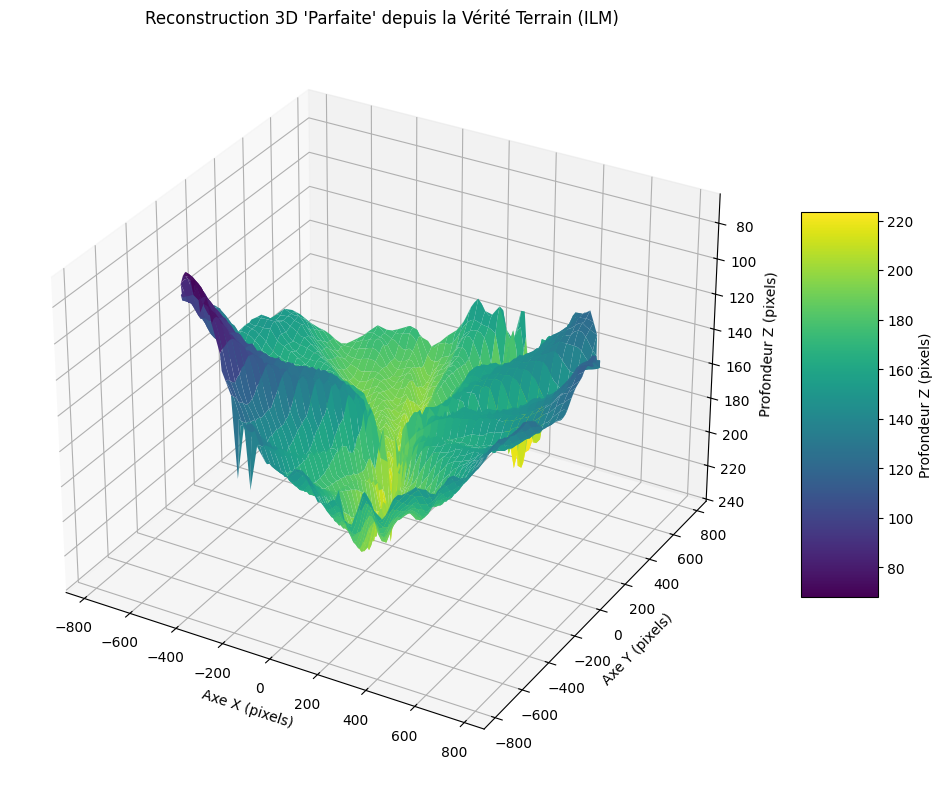

In [ ]:
# --- Point d'entrée pour la reconstruction 3D "parfaite" ---

dossier_verite_terrain = r"R_BIN1\R_BIN1\01_CAB_OD"

if os.path.isdir(dossier_verite_terrain):
    reconstruct_3d_from_ground_truth(dossier_verite_terrain)
else:
    print(f"ERREUR : Le dossier de vérité terrain n'a pas été trouvé à l'emplacement suivant :")
    print(dossier_verite_terrain)
    print("Veuillez vérifier et corriger le chemin dans la variable 'dossier_verite_terrain'.")

<h1> outil de navigation de données


In [ ]:
class DualImageNavigatorVerticalStrict: 
    def __init__(self, root):
        self.root = root
        self.root.title("Comparateur d'Images (Superposé Strict)")
        self.root.geometry("800x800")

        # --- Cadre principal ---
        main_frame = tk.Frame(root)
        main_frame.pack(expand=True, fill="both")

        main_frame.grid_rowconfigure(0, weight=1) 
        main_frame.grid_rowconfigure(1, weight=1)
     
        main_frame.grid_columnconfigure(0, weight=1)

        # --- Données pour le panneau HAUT ---
        self.image_list_top = []
        self.current_index_top = -1
        self.image_tk_top = None

        # --- Données pour le panneau BAS ---
        self.image_list_bottom = []
        self.current_index_bottom = -1
        self.image_tk_bottom = None

        self.panel_top = self.create_image_panel(main_frame, "top")
        self.panel_top.grid(row=0, column=0, sticky="nsew", padx=5, pady=5) 

   
        self.panel_bottom = self.create_image_panel(main_frame, "bottom")
        self.panel_bottom.grid(row=1, column=0, sticky="nsew", padx=5, pady=5)

        self.root.bind('<a>', lambda event: self.prev_image('top'))
        self.root.bind('<d>', lambda event: self.next_image('top'))
        self.root.bind('<Left>', lambda event: self.prev_image('bottom'))
        self.root.bind('<Right>', lambda event: self.next_image('bottom'))

    def create_image_panel(self, parent_frame, panel_id):
        panel_frame = tk.LabelFrame(parent_frame, text=f"Panneau {panel_id.capitalize()}", padx=10, pady=10)
    
        controls_frame = tk.Frame(panel_frame)
        controls_frame.pack(pady=5, fill="x")

        btn_choose_folder = tk.Button(controls_frame, text="Choisir Dossier",
                                      command=lambda p_id=panel_id: self.load_folder(p_id))
        btn_choose_folder.pack(side=tk.LEFT, padx=2)

        btn_prev = tk.Button(controls_frame, text="<<",
                             command=lambda p_id=panel_id: self.prev_image(p_id), state=tk.DISABLED)
        btn_prev.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_prev_{panel_id}", btn_prev)

        btn_next = tk.Button(controls_frame, text=">>",
                             command=lambda p_id=panel_id: self.next_image(p_id), state=tk.DISABLED)
        btn_next.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_next_{panel_id}", btn_next)

        lbl_info = tk.Label(controls_frame, text="Aucune image")
        lbl_info.pack(side=tk.LEFT, padx=5, expand=True, fill="x")
        setattr(self, f"lbl_info_{panel_id}", lbl_info)

        image_display_frame = tk.Frame(panel_frame, relief="sunken", borderwidth=1)
        image_display_frame.pack(expand=True, fill="both")
        image_display_frame.pack_propagate(False) 
        setattr(self, f"image_display_frame_{panel_id}", image_display_frame)

        lbl_image = tk.Label(image_display_frame)
        lbl_image.pack(expand=True, fill="both")
        setattr(self, f"lbl_image_{panel_id}", lbl_image)

        return panel_frame

    def load_folder(self, panel_id):
        folder_path = filedialog.askdirectory()
        if not folder_path: return

        image_list = []
        valid_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.tif', '.webp')
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(valid_extensions):
                image_list.append(os.path.join(folder_path, filename))

        if not image_list:
            messagebox.showinfo("Info", f"Aucune image trouvée pour le panneau {panel_id}.")
            current_index = -1
            getattr(self, f"lbl_image_{panel_id}").config(image='')
            setattr(self, f"image_tk_{panel_id}", None)
        else:
            image_list.sort()
            current_index = 0

        setattr(self, f"image_list_{panel_id}", image_list)
        setattr(self, f"current_index_{panel_id}", current_index)

        if image_list:
            self.root.update_idletasks()
            self.display_image(panel_id)

        self.update_button_states(panel_id)
        self.update_image_info(panel_id)

    def display_image(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        lbl_image_widget = getattr(self, f"lbl_image_{panel_id}")
        image_display_frame = getattr(self, f"image_display_frame_{panel_id}")

        if not image_list or current_index < 0:
            lbl_image_widget.config(image='')
            setattr(self, f"image_tk_{panel_id}", None)
            return

        image_path = image_list[current_index]
        try:
            img_pil = Image.open(image_path)
            image_display_frame.update_idletasks()
            frame_width = image_display_frame.winfo_width()
            frame_height = image_display_frame.winfo_height()

            if frame_width <= 1 or frame_height <= 1:
                self.root.update_idletasks() 
                parent_panel_frame = image_display_frame.master 
                parent_panel_frame.update_idletasks()

                frame_width = parent_panel_frame.winfo_width() - 20
                frame_height = parent_panel_frame.winfo_height() - (getattr(self, f"controls_frame_{panel_id}", controls_frame).winfo_height() + 20) # -hauteur controles et padding

                if frame_width <=1 : frame_width = 300
                if frame_height <=1 : frame_height = 200


            img_width, img_height = img_pil.size
            if img_width == 0 or img_height == 0:
                raise ValueError("Image dimensions are zero.")
            
            ratio = min(frame_width / img_width, frame_height / img_height)

            new_width = max(1, int(img_width * ratio))
            new_height = max(1, int(img_height * ratio))
            img_resized = img_pil.resize((new_width, new_height), Image.Resampling.LANCZOS)

            image_tk = ImageTk.PhotoImage(img_resized)
            lbl_image_widget.config(image=image_tk)
            setattr(self, f"image_tk_{panel_id}", image_tk) 

        except Exception as e:
            messagebox.showerror("Erreur", f"Panneau {panel_id}: Impossible de charger {image_path}\n{e}")
            if image_list: 
                image_list.pop(current_index)
                if current_index >= len(image_list) and image_list:
                    current_index = len(image_list) -1
                elif not image_list:
                    current_index = -1
                setattr(self, f"current_index_{panel_id}", current_index)
                if current_index != -1: self.display_image(panel_id)
                else:
                    lbl_image_widget.config(image='')
                    setattr(self, f"image_tk_{panel_id}", None)
            self.update_button_states(panel_id)
            self.update_image_info(panel_id)

    def next_image(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        if image_list and current_index < len(image_list) - 1:
            current_index += 1
            setattr(self, f"current_index_{panel_id}", current_index)
            self.display_image(panel_id)
        self.update_button_states(panel_id)
        self.update_image_info(panel_id)

    def prev_image(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        if image_list and current_index > 0:
            current_index -= 1
            setattr(self, f"current_index_{panel_id}", current_index)
            self.display_image(panel_id)
        self.update_button_states(panel_id)
        self.update_image_info(panel_id)

    def update_button_states(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        btn_prev = getattr(self, f"btn_prev_{panel_id}")
        btn_next = getattr(self, f"btn_next_{panel_id}")

        if not image_list or current_index == -1:
            btn_prev.config(state=tk.DISABLED)
            btn_next.config(state=tk.DISABLED)
        else:
            btn_prev.config(state=tk.NORMAL if current_index > 0 else tk.DISABLED)
            btn_next.config(state=tk.NORMAL if current_index < len(image_list) - 1 else tk.DISABLED)

    def update_image_info(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        lbl_info = getattr(self, f"lbl_info_{panel_id}")

        if image_list and current_index != -1:
            filename = os.path.basename(image_list[current_index])
            lbl_info.config(text=f"{current_index + 1}/{len(image_list)}: {filename[:30]}")
        else:
            lbl_info.config(text="Aucune image")

    def create_image_panel(self, parent_frame, panel_id):
        panel_frame = tk.LabelFrame(parent_frame, text=f"Panneau {panel_id.capitalize()}", padx=10, pady=10)

        controls_frame = tk.Frame(panel_frame)
        controls_frame.pack(pady=5, fill="x")
        setattr(self, f"controls_frame_{panel_id}", controls_frame)

        btn_choose_folder = tk.Button(controls_frame, text="Choisir Dossier",
                                      command=lambda p_id=panel_id: self.load_folder(p_id))
        btn_choose_folder.pack(side=tk.LEFT, padx=2)

        btn_prev = tk.Button(controls_frame, text="<<",
                             command=lambda p_id=panel_id: self.prev_image(p_id), state=tk.DISABLED)
        btn_prev.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_prev_{panel_id}", btn_prev)

        btn_next = tk.Button(controls_frame, text=">>",
                             command=lambda p_id=panel_id: self.next_image(p_id), state=tk.DISABLED)
        btn_next.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_next_{panel_id}", btn_next)

        lbl_info = tk.Label(controls_frame, text="Aucune image")
        lbl_info.pack(side=tk.LEFT, padx=5, expand=True, fill="x")
        setattr(self, f"lbl_info_{panel_id}", lbl_info)

        image_display_frame = tk.Frame(panel_frame, relief="sunken", borderwidth=1)
        image_display_frame.pack(expand=True, fill="both")
        image_display_frame.pack_propagate(False)
        setattr(self, f"image_display_frame_{panel_id}", image_display_frame)

        lbl_image = tk.Label(image_display_frame)
        lbl_image.pack(expand=True, fill="both")
        setattr(self, f"lbl_image_{panel_id}", lbl_image)

        return panel_frame

<h2> Execution du navigateur de données

In [ ]:
# root = tk.Tk()
# app = DualImageNavigatorVerticalStrict(root)
# root.mainloop()